# SYDE 556 Final Project
* Parsa Torabian
* 20554368
* p2torabi

## Table of Contents
* System Description
* Design Specifications
* Implementation
* System Evaluation
    * Experiments and tuning
    * Discussion
    * Further Work
* References

### System Description
<p>
The system modelled is a motion discrimination task based on experiments performed on rhesus monkeys. The model is based around the paper published by Gopathy Purushothaman and David C Bradley titled 'Neural population code for fine perceptual decisions in area MT' [1] which from now on will simply be referred to as "the paper". The monkeys were trained to identify a direction of motion as either clockwise (CW) or counter-clockwise (CCW) with respect to a reference motion straight up. However, we decided that the model should work regardless of the reference motion, much like others have modelled [3]. The direction of motion for both the reference and test were presented to the monkeys in the form of random dot kinematograms (RDK), but this was not modelled in the system and instead the vectors representing the direction of motion are direct inputs to the system. The motor response of the monkeys in the form of eye saccades has also been left out of the model, with an output of 1 indicating comprehension of CW and an output of -1 indicating CCW.
</p>

![1](images/Experiment1.jpg)

<p>The model's algorithm first stores the reference vector in working memory before computing it's CW orthogonal vector. Then the dot product of the test vector and the reference's orthogonal vector are taken. The result is the amount of projection of the test vector onto the CW side of the reference vector. Therefore, a positive value indicates that the test vector is CW to the reference vector, and a negative value indicates that the test vector is CCW to the referenece vector. Since we do not care for the magnitude of this projection and merely it's sign, we amplify the result to ease discrimination. Below is a picture of the model in the Nengo-GUI</p>
    
![title](images/Model1.png)

<p>Stim_ref and Stim_test are 2D vectors which represent the direction of motion of the reference and test RDKs respectfully. These inputs are then fed into working memory (the grey boxes), which store the value of these vectors in the 'output' ensembles for future use. This is done by first passing the stim values into a 'diff' ensemble which tracks the difference between the currently stored value and the stim inputs before feeding this difference into an integrator. The reason this was done was to accomodate a control signal, which would act to prevent any changes to the stored values once the motion vector stimulus disappeared. The connection between the reference's 'output' and 'orthogonal' ensembles computes the CW orthogonal of the reference vector and stores it in 'orthogonal'. The test vector and orthogonal vectors are then fed into a 4D ensemble labelled 'dot_product', which then computes the amplified dot product of its input vectors in its connection to the 'CW' ensemble. The polarity of 'CW' then becomes positive for a test vector clockwise to the reference or negative for a test vector counter-clockwise to the reference.</p>

## System Specifications
<p>We can break down our model into three sections and attribute each section to a particular area in the brain. Electrophysical data seems to suggest that neurons in the supplemental eye field (SEF) can be seen as responsible for remembering visual motion [4]. We can thus consider the working memory blocks to belong to that area. Middle Temporal (MT) visual area  plays a major role in the perception of motion for which we can consider housing the 'orthogonal' and 'dot_product' ensembles. Finally, neurons in the lateral intraparietal area (LIP) are responsible for the categorization and subsequent behavioural response [5], which we can consider the role of CW. 

<p>From the paper we can find maximum firing rates of MT neurons to be around 50-60Hz and around 100 neurons measured to participate in a fine discrimination task with a fixed reference. However, our model takes into account variable reference motions and other spiking models that do so have used at least 2000 neurons in their model. Thus we will take 100 neurons to be a starting point and we will later analyze the effect of changing this value. This sort of consideration applies to the SEF ensembles as well where 208 neurons where analyzed in the paper that determined its function. Firing rates for SEF and LIP ensembles were also lifted from the papers that determined their function. We do not know the number of neurons that are suppose to be in the CW ensemble, but since it is the output of the system and merely represents a boolean value, its number of neurons is inconsequential.</p>

<p>Regard synaptic time constants, we used the classic 100 millisecond on the recurrent connection of the working memory units in order to emulate simple integration. This is also a parameter which we can later tune and characterize its effects. Since we are not too interested in reaction time or dealing with high frequency values, the other connection synapses are left unspecified. However, this model could also be used to estimate reaction time if the appropriate synaptic time constants for each section were determined.</p>

<br>
* MT Ensembles: orthogonal, dot_product
    * Maximum Firing Rates: 35-60Hz
    * Number of Neurons: ~100

* SEF Ensembles: reference and test working memory modules
    * Maximum Firing Rates: 35-100Hz
    * Number of Neurons: ~208
* LIP Ensemble: CW
    * Maximum Firing Rates: 35-50Hz
    * Number of Neurons: Unknown

## Implementation

In [10]:
import nengo
from nengo.dists import Uniform
import numpy as np

def get_model(model=None, params={}):
    def working_mem(): #SEF
        N= 200 if "N_SEF" not in params else params["N_SEF"]
        with nengo.Network() as Integrator:
            recurrent_tau = 0.1 if "recurrent_tau" not in params else params["recurrent_tau"]
            tau = 0.1
            strength=1 #connection strength
            Integrator.diff = nengo.Ensemble(n_neurons=N//2, 
                                             dimensions=2, max_rates=Uniform(35,100))
            Integrator.value = nengo.Ensemble(n_neurons=N//2, 
                                              dimensions=2, max_rates=Uniform(35,100))

            nengo.Connection(Integrator.diff, Integrator.value, synapse=tau)
            nengo.Connection(Integrator.value, Integrator.diff, transform=-1)
            nengo.Connection(Integrator.value, Integrator.value, synapse=recurrent_tau)

            Integrator.output = Integrator.value
            Integrator.input = Integrator.diff

        return Integrator

    if model is None : model = nengo.Network()
    with model:
#        model.stim_ref #Define in the model you pass in
        reference = working_mem()
        model.ref_p = nengo.Probe(reference.output)
        nengo.Connection(model.stim_ref, reference.input)

#         model.stim_test #Define in the model you pass in
        test = working_mem()
        model.test_p = nengo.Probe(test.output)
        nengo.Connection(model.stim_test, test.input)

#         stim_control #Define in the model you pass in
        def inhibitRef(control):
            if control == 0:
                return [0]*reference.input.n_neurons
            return [-10]*reference.input.n_neurons
        def inhibitTest(control):
            if control == 1:
                return [0]*test.input.n_neurons
            return [-10]*test.input.n_neurons
        nengo.Connection(model.stim_control, reference.input.neurons, function=inhibitRef)
        nengo.Connection(model.stim_control, test.input.neurons, function=inhibitTest)

        #Returns the CW orthogonal of a vector
        def ortho(A):
            A_x, A_y = A
            return (A_y, -1*A_x)

        N = 100 if "N_MT" not in params else params["N_MT"]
        #We will assign 'orthogonal' half as many neurons as 'dot_product' 
        #because it represents less dimensions
        orthogonal = nengo.Ensemble(n_neurons= N//3, dimensions=2,max_rates=Uniform(35,60))
        model.ortho_p = nengo.Probe(orthogonal)
        nengo.Connection(reference.output, orthogonal, function=ortho)

        dot_product = nengo.Ensemble(n_neurons=N - N//3, 
                                     dimensions=4, max_rates=Uniform(35,60))
        model.dotprod_p = nengo.Probe(dot_product)
        nengo.Connection(orthogonal[0], dot_product[0])
        nengo.Connection(orthogonal[1], dot_product[1])
        nengo.Connection(test.output[0], dot_product[2])
        nengo.Connection(test.output[1], dot_product[3])

        def dot(A):
            orthoX, orthoY, motionX, motionY = A
            return 10*(orthoX*motionX + orthoY*motionY)
        N_CW = 100 if "N_CW" not in params else params["N_CW"]
        CW = nengo.Ensemble(n_neurons=N_CW, dimensions=1, max_rates=Uniform(35,50))
        model.CW_p = nengo.Probe(CW)
        nengo.Connection(dot_product, CW, function=dot)
        
        return model

## System Evaluation
#### Experiments
<p>Two experiments were used to evaluate the model. The first is a coarse CW/CCW categorization task where the system is presented by a random reference vector followed by another random test vector after 1 second, for which we expect near perfect results. The second is a fine categorization task where the test vector is angled at between 0-3 degrees from a reference vector pointing straight up. The results of the fine direction categorization test can be directly compared to the behavioural results which state that monkeys are adept at categorization to within 2 degrees. Since we primarily lack information regarding the number of neurons that would be used in such a task, we will be trying a range of values and analyzing the effects. We will run all results over multiple instances to account for the inherent randomness of the model.</p>
<br>
<p>We'll begin with the coarse categorization over 20 trials</p>

In [42]:
%pylab inline
#Experiment 1: Coarse CW/CCW categorization, 10 trials
trials = 20
reference_angles = np.random.uniform(0, 2*np.pi, trials)
test_angles = np.random.uniform(0, 2*np.pi, trials)
abs_diff = np.vectorize(lambda x,y: np.abs(x-y))
diff_angles = abs_diff(reference_angles, test_angles)
#determine mathematically if angle b is clockwise to a
def determine_cw(a, b):
    diff = a - b
    if (a-b < 0): diff = diff+2*np.pi
    if (diff < np.pi): return True 
    else: return False
ideal_results = (np.vectorize(determine_cw))(reference_angles, test_angles)

#define inputs to the model
#theta is angle of unit vector
def generateInputRef(theta):
    def InputRef(t):
        return (np.cos(theta), np.sin(theta)) if t < 1 else (0,0)
    return InputRef
def generateInputTest(theta):
    def InputTest(t):
        return (np.cos(theta), np.sin(theta)) if t > 1.75 and t < 2.75 else (0,0)
    return InputTest
def controlSignal(t):
    if t < 1:
        return 0
    elif t > 1.75 and t < 2.75:
        return 1
    return -1
    
def successRate(reference_angles, test_angles, ideal_results, stats=False, params={}):
    success = 0
    failure = 0
    trials = len(reference_angles)
    for j in range(trials):
        model = nengo.Network()
        with model:
            model.stim_ref = nengo.Node(generateInputRef(reference_angles[j]))
            model.stim_test = nengo.Node(generateInputTest(test_angles[j]))
            model.stim_control = nengo.Node(controlSignal)
        model = get_model(model, params)
        sim = nengo.Simulator(model, progress_bar=False)
        sim.run(3)
        t = sim.trange()
        if stats: #if we care to get more detailed stats
            if j==0: #To get average values of each ensemble
                ref_values = sim.data[model.ref_p]
                test_values = sim.data[model.test_p]
                ortho_values = sim.data[model.ortho_p]
                dotProd_values = sim.data[model.dotprod_p]
            else:
                ref_values = np.add(ref_values,  sim.data[model.ref_p])
                test_values = np.add(test_values,  sim.data[model.test_p])
                ortho_values = np.add(ortho_values,  sim.data[model.ortho_p])
                dotProd_values = np.add(dotProd_values,  sim.data[model.dotprod_p])
                
        final_reading = sim.data[model.CW_p][-1]
        if final_reading < 0: #CCW
            result = False
        else: #CW
            result = True

        if (result == ideal_results[j]):
            success += 1
        else:
            failure += 1
    print(str(100*(success/(success+failure)))+"% success rate")
    if stats:
        return {"ref": ref_values*(1/trials), 
                "test": test_values*(1/trials), 
                "ortho": ortho_values*(1/trials), 
                "dotprod":dotProd_values*(1/trials),
                "t" : t,
                "success": success,
                "failure": failure
               }
    else:
        return {"success" : success, "failure": failure}

successRate(reference_angles, test_angles, ideal_results)

Populating the interactive namespace from numpy and matplotlib
95.0% success rate


{'failure': 1, 'success': 19}

As expected, the coarse categorization test worked nearly perfectly. The algorithm at work is mathematically sound and we are only dealing with representational error. It should be noted that at this point the model is using around 600 neurons, a fraction of what other spiking neuron models use for this task [3]. 
<br><br>
We will now look at fine discrimination task. In the interest of saving time, we will focus on tuning our model around the biological categorization threshold of 1.7 degrees [1] before running the full experiment from 0-3 degrees. Here we will be adjusting the number of neurons until we can get around an 80% success rate at 1.7 degrees. The hypothesis is that a greater number of neurons will result in a smaller discrimination threshold. 

30.0% success rate


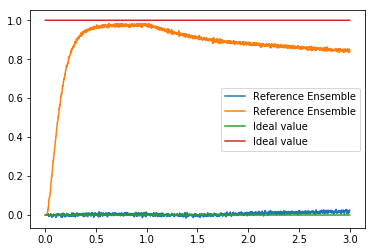

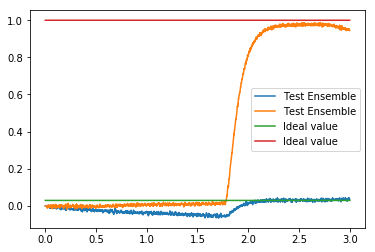

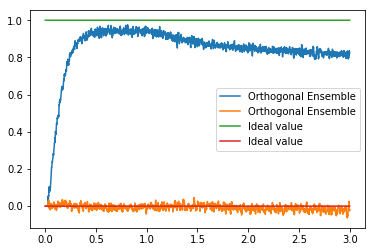

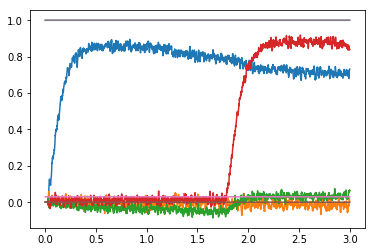

<Figure size 432x288 with 0 Axes>

In [40]:
def fineTuningTest(trials=20, params={}):
    reference_angle = np.ones(trials)*(np.pi/2)
    test_angle = np.ones(trials)*(np.pi/2 - 1.7*(np.pi/180))
    ideal_results = [False]*trials
    stats = successRate(reference_angle, test_angle, ideal_results, stats=True, params=params)
    t = stats["t"]
    t_steps = len(t)
    ideal_ref = [(0, 1)]*t_steps
    ideal_test = [(np.cos(test_angle[0]), np.sin(test_angle[0]))]*t_steps
    ideal_ortho = [(1,0)]*t_steps
    plot(t, stats["ref"], label="Reference Ensemble")
    plot(t, ideal_ref, label="Ideal value")
    legend()
    figure()
    plot(t, stats["test"], label="Test Ensemble")
    plot(t, ideal_test, label="Ideal value")
    legend()
    figure()
    plot(t, stats["ortho"], label="Orthogonal Ensemble")
    plot(t, ideal_ortho, label="Ideal value")
    legend()
    figure()
    plot(t, stats["dotprod"], label="Dot_product Ensemble")
    plot(t, ideal_ortho, label="Ideal value")
    plot(t, ideal_test, label="Ideal value")
    figure()
    return stats
x1 = fineTuningTest()

As we can see above, the memory neurons tend to drift downwards after they stop recieving input. Afterwards the MT neurons do a relatively faithful job preserving the signals. At this point we have around a 30% success rate which we might be able to improve by cranking up the number of neurons in the memory components.

50.0% success rate


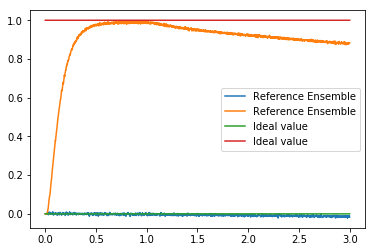

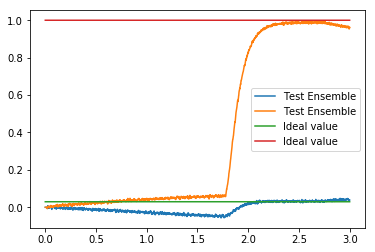

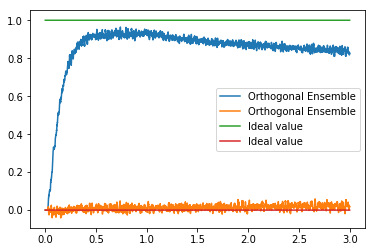

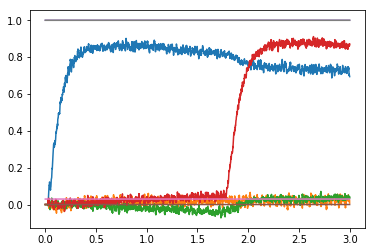

<Figure size 432x288 with 0 Axes>

In [39]:
params = {"N_SEF":400}
x2 = fineTuningTest(params=params)

Doubling the number of neurons in the memory cells didn't do much to change the drooping, and we noticed a nice increase in accuracy but still significantly lower than the desired 80%. This seems to imply that if this algorithm is indeed representative of how monkeys categorize motion, then a more complicated model is needed for the visual memory than the simple integrator we have here. We can test whether or not poor categorization performance is soley due to the memory droop by directly driving the MT ensembles.  

In [47]:
def modified_model():
    model = nengo.Network()
    with model:
        stim_ortho = nengo.Node([1,0])
        theta = np.pi/2 - 1.7*(np.pi/180)
        stim_test = nengo.Node([np.cos(theta), np.sin(theta)])

        N = 400
        orthogonal = nengo.Ensemble(n_neurons= N//3, dimensions=2,max_rates=Uniform(35,60))
        model.ortho_p = nengo.Probe(orthogonal)
        nengo.Connection(stim_ortho, orthogonal)

        dot_product = nengo.Ensemble(n_neurons=N - N//3, 
                                     dimensions=4, max_rates=Uniform(35,60))
        model.dotprod_p = nengo.Probe(dot_product)
        nengo.Connection(orthogonal[0], dot_product[0])
        nengo.Connection(orthogonal[1], dot_product[1])
        nengo.Connection(stim_test[0], dot_product[2])
        nengo.Connection(stim_test[1], dot_product[3])

        def dot(A):
            orthoX, orthoY, motionX, motionY = A
            return 10*(orthoX*motionX + orthoY*motionY)
        N_CW = 50
        CW = nengo.Ensemble(n_neurons=N_CW, dimensions=1, max_rates=Uniform(35,50))
        model.CW_p = nengo.Probe(CW)
        nengo.Connection(dot_product, CW, function=dot)

    return model

success = 0
failure = 0
for i in range(20):
    model = modified_model()
    sim = nengo.Simulator(model, progress_bar=False)
    sim.run(1)
    final_reading = sim.data[model.CW_p][-1]
    if final_reading < 0: #CCW
        result = False
    else: #CW
        result = True

    if (result == False):
        success += 1
    else:
        failure += 1

print(str(100*(success/(success+failure)))+"% success rate")

35.0% success rate


Surprisingly we still see a very low success rate, suggesting that this model is not a very good model for fine direction categorization.

#### Discussion
<p>This algorithm and model was chosen because it used simple components and computed functions that neurons were good at approximating. This was deemed necessary since identifying and categorizing motion is a very basic function that shouldn't require a highly sophisticated brain. Furthermore, each of the ensembles represents a value which would be conceivably useful in other functions and percepts.</p>
<p>Furthermore, the paper mentioned that "sampled neurons have poor ideal-observer performance for fine discrimination when compared to the exquisite performance reported for a coarse discrimination task". This would have worked well with our model, given that there would be a weak correlation between individual neuron activity and the final categorization decision within MT ensembles, whilst there would be very strong correlation in the LIP neurons consistent with the experimental data.</p>
<p>Our model was very good at determining coarse motion but failed to replicate the fine directional categorization that primates are capable of. </p>

#### Further Work
<p>Owing to time constraints, we could not do a more in depth literature review to determine synaptic time constants. As discussed above, it would not have too much of an impact on our current experiments as none dealt with sophisticated dynamics or high frequency values, but it would give us the ability to make predictions regarding reaction time.</p>

## References
<li>[1]G. Purushothaman and D. Bradley, "Neural population code for fine perceptual decisions in area MT", Nature Neuroscience, vol. 8, no. 1, pp. 99-106, 2004.</li>
<br>
<li>[2]M. Shadlen and W. Newsome, "Motion perception: seeing and deciding.", Proceedings of the National Academy of Sciences, vol. 93, no. 2, pp. 628-633, 1996.</li>
<br>
<li>[3]L. Yu, S. Wu and D. Wang, "Neural implementation of categorization in a motion discrimination task", Neurocomputing, vol. 216, pp. 709-717, 2016.</li>
<br>
<li>[4]N. Shichinohe, T. Akao, S. Kurkin, J. Fukushima, C. Kaneko and K. Fukushima, "Memory and Decision Making in the Frontal Cortex during Visual Motion Processing for Smooth Pursuit Eye Movements", Neuron, vol. 62, no. 5, pp. 717-732, 2009.</li>
<br>
<li>[5]M. Leon and M. Shadlen, "Exploring the Neurophysiology of Decisions", Neuron, vol. 21, no. 4, pp. 669-672, 1998.</li>